In [42]:
import numpy as np
from typing import Callable
import matplotlib.pyplot as plt


In [43]:
# Differential drive kinematics model found at 
# https://se.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html

class DifferentialDriveKinematicsModel:
  def f_continous(
        self, 
        x     : np.ndarray, 
        u     : np.ndarray
      ) -> np.ndarray:
    """
    Continous function model

    Input parameters:
      x = [x, y, theta]^T : states
      u = [v, omega]^T    : control inputs
    """

    theta = x[2]
    x_dot = np.array(
      [
        [np.cos(theta), 0],
        [np.sin(theta), 0],
        [0, 1]
      ], 
      dtype=np.float
    ) @ u 
    return x_dot.reshape((3, 1))

  def F_continous(
        self, 
        x     : np.ndarray, 
        u     : np.ndarray
      ) -> np.ndarray:
    """
    Continous Jacobian of state transition

    Input parameters:
      x = [x, y, theta]^T : states
      u = [v, omega]^T    : control inputs
    """

    v = u[0]
    theta = x[2]
    return np.array(
      [
        [0, 0, -np.sin(theta) * v],
        [0, 0, np.cos(theta) * v],
        [0, 0, 0]
      ],
      dtype=float
    )

  def g_continous(
        self, 
        x     : np.ndarray, 
        u     : np.ndarray
      ) -> np.ndarray:
    """
    Continous measurement model of the position. 
    This model does not use the 'control'-signals u, as it is only y = g(x) 

    Input parameters:
      x = [x, y, theta]^T : states
      u = [v, omega]^T    : control inputs
    """

    return x[:2].reshape((2, 1))

  def G_continous(
        self, 
        x     : np.ndarray, 
        u     : np.ndarray
      ) -> np.ndarray:
    """
    Continous Jacobian of measurement model.
    This model does not use the 'control'-signals u, as it is only y = g(x) 

    Input parameters:
      x = [x, y, theta]^T : states
      u = [v, omega]^T    : control inputs
    """

    return np.eye(2, 3)


In [44]:
class GroundTruth:
  def __init__(
        self, 
        continous_model : Callable, 
        dt              : float, 
        num_states      : int
      ) -> None:
    """
    Generates the ground-truth data

    Uses the continous model to generate some of the data, and therefore
    assumes the model to be exact - which it in reality will not
    """
    self.continous_model : Callable = continous_model
    self.dt : float = dt

    # Parameters for the reference-models (randomly chosen)
      # Velocity 
    self.tau_v : float = 2.5
    self.k_v : float = 1

      # Angular rate
    self.tau_omega : float = 0.5
    self.k_omega : float = 1 

    # Initial values
    self.v : float = 0
    self.omega : float = 0
    self.x : np.ndarray = np.zeros((num_states, 1))


  def _velocity_reference_model(
        self, 
        v     : float, 
        v_ref : float
      ) -> float:
    """
    First-order model generating the velocities
    """
    v_dot = (1 / self.tau_v) * (-v + self.k_v * v_ref)
    return v + self.dt * v_dot

  def _angular_rate_reference_model(
        self, 
        omega     : float, 
        omega_ref : float
      ) -> float:
    """
    First-order model generating the velocities
    """
    omega_dot = (1 / self.tau_v) * (-omega + self.k_v * omega_ref)
    return omega + self.dt * omega_dot

  def ground_truth(
        self, 
        v_ref     : float, 
        omega_ref : float
      ) -> np.ndarray:
    """
    Calculates the ground truth based on the desired velocity and 
    the desired angular rate
    """
    
    self.v = self._velocity_reference_model(v=self.v, v_ref=v_ref)
    self.omega = self._angular_rate_reference_model(omega=self.omega, omega_ref=omega_ref)

    u = np.array((self.v, self.omega)).T
    x_dot = self.continous_model.f_continous(x=self.x, u=u)
    
    self.x = self.x + self.dt * x_dot
    return self.x, u


In [45]:
class EKF:
  def __init__(
        self, 
        continous_model : Callable, 
        x0              : np.ndarray, 
        P0              : np.ndarray,
        Qd              : np.ndarray,
        Rd              : np.ndarray,
        dt              : float
      ) -> None:
    """
    EKF for estimating a general continous function model

    Input-parameters:
      continous_model : function model to call
      x0              : initial state estimate
      P0              : initial covariance 
      Qd              : process noise - assumed discretized
      Rd              : measurement noise - assumed discretized 
      dt              : time-step [s]
    """

    self.continous_model : Callable = continous_model 
    
    self.x_hat : np.ndarray = x0
    self.P_hat : np.ndarray = P0

    # Assumning that the noise-matrices are already discretized
    self.Qd : np.ndarray = Qd 
    self.Rd : np.ndarray = Rd

    self.dt : float = dt
    self.n_states : int = self.x_hat.shape[0]


  def step(
        self, 
        u     : np.ndarray, 
        y     : np.ndarray = None
      ) -> tuple:
    """
    Runs a single step of the EKF

    Input-parameters:
      u     : control input to drive the function model
      y     : measurements. Assumed to be None if no measurements available 

    Output-parameters:
      x_hat : most recent state estimate
      P_hat : most recent covariance
    """
    # Assuming that an ERK1 - discretization is sufficient
    F = np.eye(self.n_states) + self.dt * self.continous_model.F_continous(x=self.x_hat, u=u) # ERK1 discretization

    # Prediction
    x_pred = self.x_hat + self.dt * self.continous_model.f_continous(x=self.x_hat, u=u) # ERK1 discretization
    P_pred = F @ self.P_hat @ F.T + self.Qd

    if y is not None:
      # Only correct the model if there are measurements
      y_pred = self.continous_model.g_continous(x=x_pred, u=u).ravel()

      # Kalman gain
      G = self.continous_model.G_continous(x=x_pred, u=u) # The measurement Jacobian will be equal for discrete and continous systems
      K = P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + self.Rd)

      # Correction 
      self.x_hat = x_pred + K @ (y - y_pred).reshape((2, 1))
      self.P_hat = (np.eye(self.n_states) - K @ G) @ P_pred 

    else:
      # If no measurements to correct, use the predictions 
      self.x_hat = x_pred
      self.P_hat = P_pred 

    return self.x_hat, self.P_hat


In [46]:
class IEKF:
  def __init__(
        self, 
        continous_model : Callable, 
        x0              : np.ndarray, 
        P0              : np.ndarray, 
        Qd              : np.ndarray, 
        Rd              : np.ndarray, 
        dt              : float,
        n_optimization  : int
      ) -> None:
    """
    Iterated EKF for estimating a general continous function model

    Input-parameters:
      continous_model : function model to call
      x0              : initial state estimate
      P0              : initial covariance 
      Qd              : process noise - assumed discretized
      Rd              : measurement noise - assumed discretized 
      dt              : time-step [s]
      n_optimization  : number of iterations to optimize the estimate
    """  
    self.continous_model : Callable = continous_model 

    # Assumning that the noise-matrices are already discretized
    self.Qd : np.ndarray = Qd 
    self.Rd : np.ndarray = Rd

    self.dt : float = dt
    self.n_states : int = x0.shape[0]

    self.x_op : np.ndarray = x0
    self.P_op : np.ndarray = P0

    self.n_optimization : int = n_optimization


  def step(
        self, 
        u     : np.ndarray, 
        y     : np.ndarray = None
      ) -> tuple:
    """
    Runs a single step of the IEKF, by iterating the EKF-estimate over @p n_optimization

    Will only iterate if there are measurements

    Input-parameters:
      u     : control input to drive the function model
      y     : measurements. Assumed to be None if no measurements available 

    Output-parameters:
      x_op  : most recent state estimate
      P_op  : most recent covariance
    """
    n_optimization = self.n_optimization
    if y is None:
      n_optimization = 1

    for iteration in range(n_optimization):
      # Assuming that an ERK1 - discretization is sufficient
      F = np.eye(self.n_states) + self.dt * self.continous_model.F_continous(x=self.x_op, u=u) # ERK1 discretization

      # Prediction
      x_pred = self.x_op + self.dt * self.continous_model.f_continous(x=self.x_op, u=u) # ERK1 discretization
      P_pred = F @ self.P_op @ F.T + self.Qd

      if y is not None:
        # Only correct the model if there are measurements
        y_op = self.continous_model.g_continous(x=self.x_op, u=u).ravel()

        # Kalman gain
        G = self.continous_model.G_continous(x=x_pred, u=u) # The measurement Jacobian will be equal for discrete and continous systems
        K = P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + self.Rd)

        # Correction 
        self.x_op = x_pred + K @ (y - y_op - (G @ (x_pred - self.x_op)).ravel()).reshape((2, 1))
        self.P_op = (np.eye(self.n_states) - K @ G) @ P_pred

      else:
        # If no measurements to correct, use the predictions 
        self.x_op = x_pred
        self.P_op = P_pred 

    return self.x_op, self.P_op


In [47]:
def run_estimates(
      num_states  : int,
      num_steps   : int,
      q_list      : list,
      r_pos_list  : list,
      r_vel_list  : list,
      use_r_in_R  : bool = True
    ) -> None:
  # Initialization of memory
  show_covariance_matrices : bool = False # Not implemented atm, but could be nice in the future

  gt_states_array : np.ndarray = np.empty((num_states, num_steps))
  ekf_state_estimates_array : np.ndarray = np.empty((num_states, num_steps))
  iekf_state_estimates_array : np.ndarray = np.empty((num_states, num_steps))
  if show_covariance_matrices:
    ekf_covariance_matrices_array : np.ndarray = np.empty((num_states, num_states, num_steps))
    iekf_covariance_matrices_array : np.ndarray = np.empty((num_states, num_states, num_steps))

  v_ref_array : np.ndarray = np.ones((1, num_steps)) * 10.0
  omega_ref_array : np.ndarray = np.ones((1, num_steps)) * (2.0 * np.pi / 180.0) 


  # Frequencies and timing 
  f_u : float = 100.0   # Velocity and angular rate
  f_x : float = 1       # Position

  dt = 1 / f_u


  # Initial values 
  x0 : np.ndarray = np.zeros((num_states, 1))
  P0 : np.ndarray = np.eye(num_states)


  Qd : np.ndarray = np.diag(q_list)
  if use_r_in_R:
    Rd : np.ndarray = np.diag(r_pos_list)
  else:
    Rd : np.ndarray = np.diag([2.0, 2.0]) # The default values


  differential_drive_model = DifferentialDriveKinematicsModel()
  ekf = EKF(
    continous_model=differential_drive_model,
    x0=x0,
    P0=P0,
    Qd=Qd,
    Rd=Rd,
    dt=dt  
  )
  iekf = IEKF(
    continous_model=differential_drive_model,
    x0=x0,
    P0=P0,
    Qd=Qd,
    Rd=Rd,
    dt=dt,
    n_optimization=10  
  )
  gt = GroundTruth(
    continous_model=differential_drive_model,
    dt=dt,
    num_states=num_states
  )


  for iteration in range(num_steps):
    v_ref = v_ref_array[0, iteration]
    omega_ref = omega_ref_array[0, iteration]

    x_exact, u_exact = gt.ground_truth(v_ref=v_ref, omega_ref=omega_ref)
    gt_states_array[:, iteration] = x_exact.ravel()

    # Injecting noise - assuming gaussian distributed noise
    # Assumption that the tuning is perfect, such that the values for Q and R
    # could be used in the noise-generation. This is of course not true in reality,
    # and one would have to tune the EKF 
    u_noise = u_exact + np.random.multivariate_normal(mean=np.zeros((len(r_vel_list))), cov=np.diag(r_vel_list))
    y_noise = None 
    if iteration % (int(f_u / f_x)) == 0 and iteration > 0:
      # Assuming that the measurement-model is exact 
      # Also assuming as above, that the noise-values used for the EKF R-matrix could be used
      y_exact = differential_drive_model.g_continous(x=x_exact, u=u_exact).ravel() 
      y_noise = y_exact + np.random.multivariate_normal(mean=np.zeros((len(r_pos_list))), cov=np.diag(r_pos_list)) 

    ekf_x_hat, ekf_P_hat = ekf.step(u=u_noise, y=y_noise)
    iekf_x_hat, iekf_P_hat = iekf.step(u=u_noise, y=y_noise)

    ekf_state_estimates_array[:, iteration] = ekf_x_hat.ravel()
    iekf_state_estimates_array[:, iteration] = iekf_x_hat.ravel()


  # Plotting the ekf_errors as well to make it easier to vizualise
  fig, ax = plt.subplots(3)
  fig.canvas.manager.set_window_title("Estimates vs ground truth")

  x_gt = gt_states_array[0, :]
  y_gt = gt_states_array[1, :]
  theta_gt = gt_states_array[2, :]

  ekf_x_hat = ekf_state_estimates_array[0, :]
  ekf_y_hat = ekf_state_estimates_array[1, :]
  ekf_theta_hat = ekf_state_estimates_array[2, :]

  iekf_x_hat = ekf_state_estimates_array[0, :]
  iekf_y_hat = ekf_state_estimates_array[1, :]
  iekf_theta_hat = ekf_state_estimates_array[2, :]


  ax[0].plot(x_gt)
  ax[0].plot(ekf_x_hat)
  ax[0].plot(iekf_x_hat)
  ax[0].legend(["Ground truth", "EKF", "IEKF"])
  ax[0].set_ylabel("x [m]")
  ax[0].set_xlabel("k [0.01s]")
  ax[0].set_title("Position in x")

  ax[1].plot(y_gt)
  ax[1].plot(ekf_y_hat)
  ax[1].plot(iekf_y_hat)
  ax[1].legend(["Ground truth", "EKF", "IEKF"])
  ax[1].set_ylabel("y [m]")
  ax[1].set_xlabel("k [0.01s]")
  ax[1].set_title("Position in y")

  ax[2].plot(theta_gt)
  ax[2].plot(ekf_x_hat)
  ax[2].plot(iekf_x_hat)
  ax[2].legend(["Ground truth", "EKF", "IEKF"])
  ax[2].set_ylabel("theta [rad]")
  ax[2].set_xlabel("k [0.01 s]")
  ax[2].set_title("Angle")


  fig, ax = plt.subplots(2)
  fig.canvas.manager.set_window_title("Comparison GT, EKF and IEKF")

  ax[0].plot(ekf_x_hat, ekf_y_hat, "r", label="EKF")
  ax[0].plot(x_gt, y_gt, "g-", label="Ground truth")
  ax[0].legend(["EKF", "Ground truth"])
  ax[0].set_ylabel("y [m]")
  ax[0].set_xlabel("x [m]")
  # ax[0].set_title("EKF vs GT")

  ax[1].plot(iekf_x_hat, iekf_y_hat, "b", label="IEKF")
  ax[1].plot(x_gt, y_gt, "g-", label="Ground truth")
  ax[1].legend(["IEKF", "Ground truth"])
  ax[1].set_ylabel("y [m]")
  ax[1].set_xlabel("x [m]")
  # ax[1].set_title("Position")

  # ax[2].plot(iekf_x_hat, iekf_y_hat, "b-", label="IEKF")
  # ax[2].plot(ekf_x_hat, ekf_y_hat, "r.", label="EKF")
  # ax[2].set_ylabel("y [m]")
  # ax[2].set_xlabel("x [m]")
  # ax[2].set_title("Position")

  # ax[1].plot(theta_gt, "g-", label="Ground truth")
  # ax[1].plot(ekf_theta_hat, "r", label="EKF estimate")
  # ax[1].plot(iekf_theta_hat, "b", label="IEKF estimate")
  # ax[1].set_ylabel("theta [rad]")
  # ax[1].set_xlabel("k [0.01 s]")
  # ax[1].set_title("Angle")


  ekf_errors = np.subtract(gt_states_array, ekf_state_estimates_array) 
  ekf_error_fig, ekf_error_ax = plt.subplots(3)
  ekf_error_fig.canvas.manager.set_window_title("EKF errors")

  ekf_x_errors = ekf_errors[0, :]
  ekf_y_errors = ekf_errors[1, :]
  ekf_theta_errors = ekf_errors[2, :]

  ekf_error_ax[0].plot(ekf_x_errors, label="Errors in x")
  ekf_error_ax[0].set_ylabel("EKF error x [m]")
  ekf_error_ax[0].set_xlabel("k [0.01 s]")
  ekf_error_ax[0].set_title("EKF error x-position")

  ekf_error_ax[1].plot(ekf_y_errors, label="Errors in y")
  ekf_error_ax[1].set_ylabel("EKF error y [m]")
  ekf_error_ax[1].set_xlabel("k [0.01 s]")
  ekf_error_ax[1].set_title("EKF error y-position")
  
  ekf_error_ax[2].plot(ekf_theta_errors, label="Errors in theta")
  ekf_error_ax[2].set_ylabel("EKF error theta [rad]")
  ekf_error_ax[2].set_xlabel("k [0.01 s]")
  ekf_error_ax[2].set_title("EKF error theta-angle")

  print("EKF")
  print("Number of x-estimates with an error greater than 1 m: ", len(np.where(np.abs(ekf_x_errors) > 1)[0]))
  print("Number of x-estimates with an error greater than 2 m: ", len(np.where(np.abs(ekf_x_errors) > 2)[0]))
  print("Number of x-estimates with an error greater than 5 m: ", len(np.where(np.abs(ekf_x_errors) > 5)[0]))
  print()


  iekf_errors = np.subtract(gt_states_array, iekf_state_estimates_array) 
  iekf_error_fig, iekf_error_ax = plt.subplots(3)
  iekf_error_fig.canvas.manager.set_window_title("IEKF errors")

  iekf_x_errors = iekf_errors[0, :]
  iekf_y_errors = iekf_errors[1, :]
  iekf_theta_errors = iekf_errors[2, :]

  iekf_error_ax[0].plot(iekf_x_errors)
  iekf_error_ax[0].set_ylabel("IEKF error x [m]")
  iekf_error_ax[0].set_xlabel("k [0.01 s]")
  iekf_error_ax[0].set_title("IEKF error x-position")

  iekf_error_ax[1].plot(iekf_y_errors)
  iekf_error_ax[1].set_ylabel("IEKF error y [m]")
  iekf_error_ax[1].set_xlabel("k [0.01 s]")
  iekf_error_ax[1].set_title("IEKF error y-position")
  
  iekf_error_ax[2].plot(iekf_theta_errors)
  iekf_error_ax[2].set_ylabel("IEKF error theta [rad]")
  iekf_error_ax[2].set_xlabel("k [0.01 s]")
  iekf_error_ax[2].set_title("IEKF error theta-angle")

  print("IEKF")
  print("Number of x-estimates with an error greater than 1 m: ", len(np.where(np.abs(iekf_x_errors) > 1)[0]))
  print("Number of x-estimates with an error greater than 2 m: ", len(np.where(np.abs(iekf_x_errors) > 2)[0]))
  print("Number of x-estimates with an error greater than 5 m: ", len(np.where(np.abs(iekf_x_errors) > 5)[0]))
  print()


  errors_ekf_vs_iekf = np.subtract(ekf_state_estimates_array, iekf_state_estimates_array)
  ekf_iekf_error_fig, ekf_iekf_error_ax = plt.subplots(3)
  ekf_iekf_error_fig.canvas.manager.set_window_title("Difference EKF and IEKF")
  ekf_iekf_error_ax[0].plot(errors_ekf_vs_iekf[0,:], label="x")
  ekf_iekf_error_ax[1].plot(errors_ekf_vs_iekf[1,:], label="y")
  ekf_iekf_error_ax[2].plot(errors_ekf_vs_iekf[2,:], label="theta")

  ekf_iekf_error_ax[0].set_ylabel("Difference EKF and IEKF x [m]")
  ekf_iekf_error_ax[0].set_xlabel("k [0.01 s]")
  ekf_iekf_error_ax[0].set_title("x-position")
  ekf_iekf_error_ax[1].set_ylabel("Difference EKF and IEKF y [m]")
  ekf_iekf_error_ax[1].set_xlabel("k [0.01 s]")
  ekf_iekf_error_ax[1].set_title("y-position")
  ekf_iekf_error_ax[2].set_ylabel("Difference EKF and IEKF theta [rad]")
  ekf_iekf_error_ax[2].set_xlabel("k [0.01 s]")
  ekf_iekf_error_ax[2].set_title("theta-angle")

EKF
Number of x-estimates with an error greater than 1 m:  7999
Number of x-estimates with an error greater than 2 m:  6465
Number of x-estimates with an error greater than 5 m:  2783

IEKF
Number of x-estimates with an error greater than 1 m:  8005
Number of x-estimates with an error greater than 2 m:  6296
Number of x-estimates with an error greater than 5 m:  2689



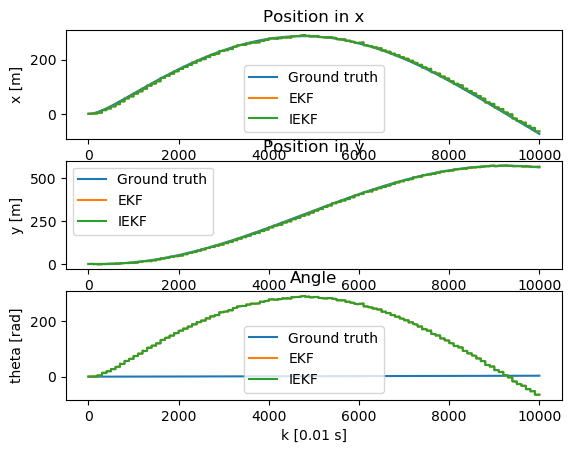

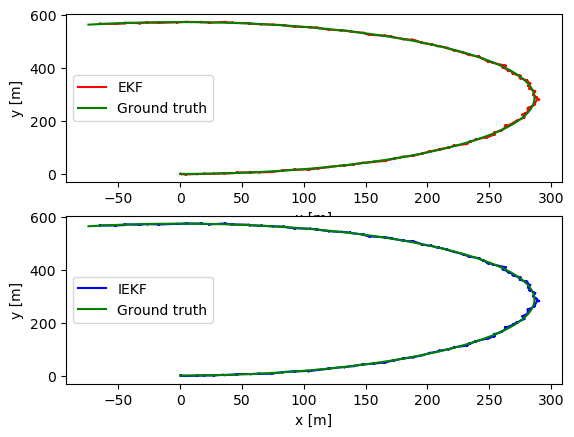

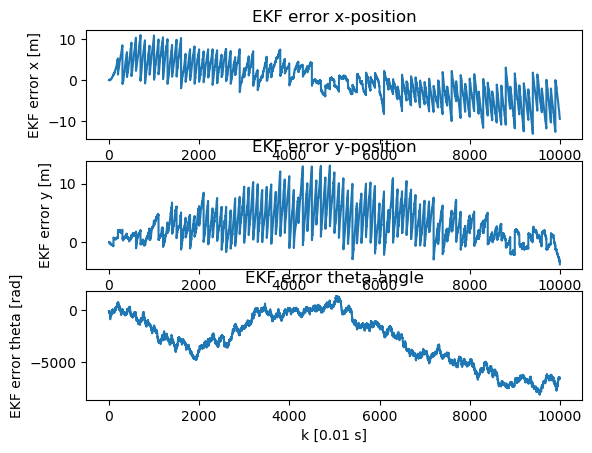

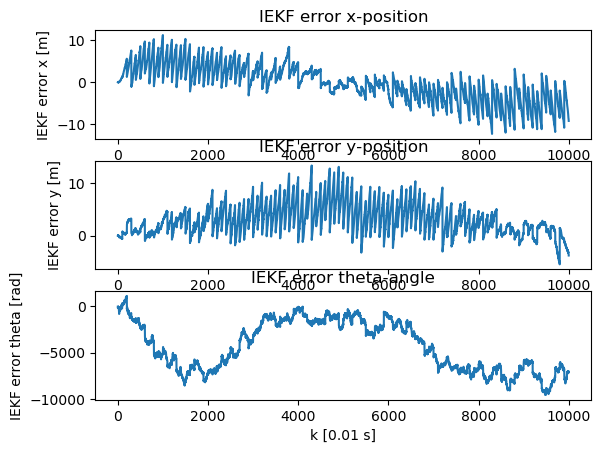

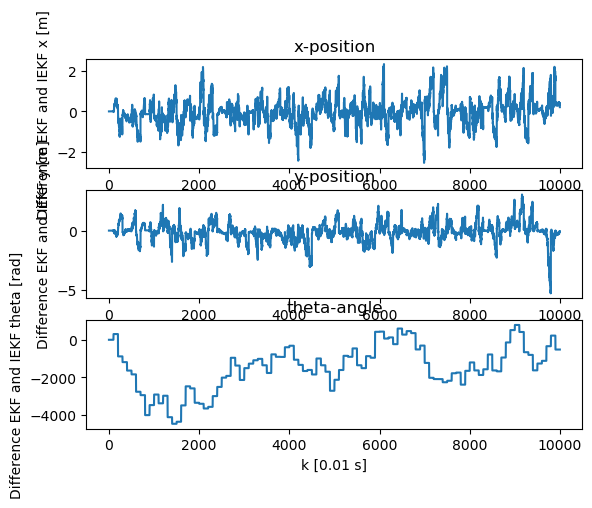

In [48]:
# High angular noise

# Noise - must be tuned
  # Process-noise
q_var = [1, 0.8, 2 * np.pi / 180.0]
  # Measurement noise
r_pos_var = [2, 2]
r_vel_var = [10, 2e9 * np.pi / 180.0]

num_states = 3
num_steps = 10000

run_estimates(
  num_states=num_states,
  num_steps=num_steps,
  q_list=q_var,
  r_pos_list=r_pos_var,
  r_vel_list=r_vel_var
)

EKF
Number of x-estimates with an error greater than 1 m:  5799
Number of x-estimates with an error greater than 2 m:  2416
Number of x-estimates with an error greater than 5 m:  175

IEKF
Number of x-estimates with an error greater than 1 m:  5759
Number of x-estimates with an error greater than 2 m:  2424
Number of x-estimates with an error greater than 5 m:  193



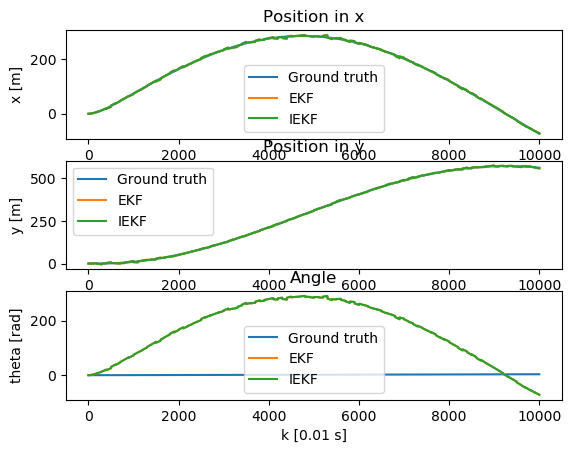

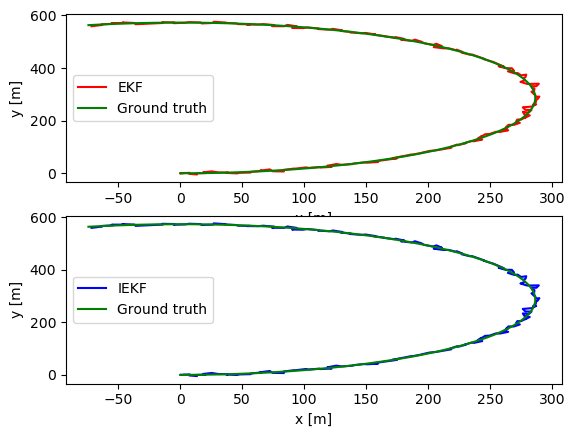

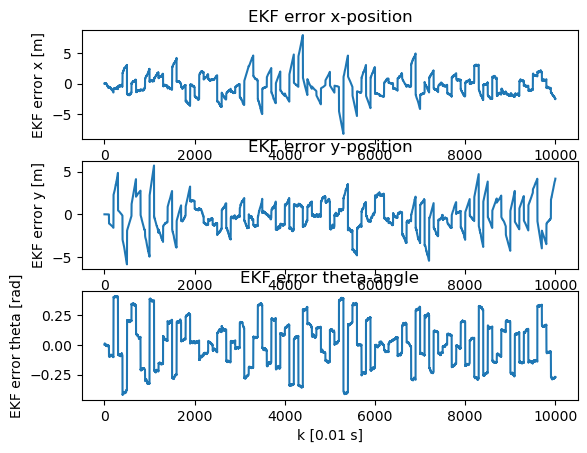

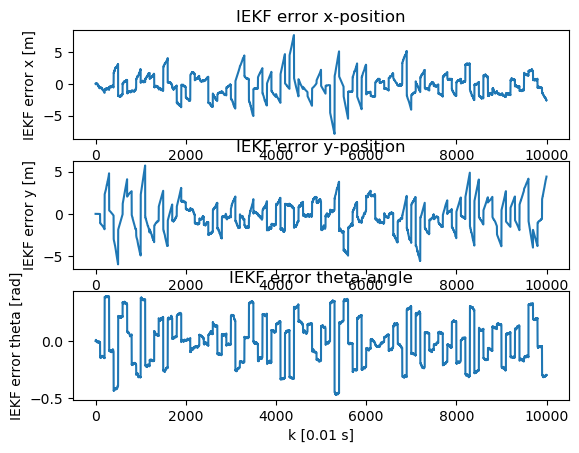

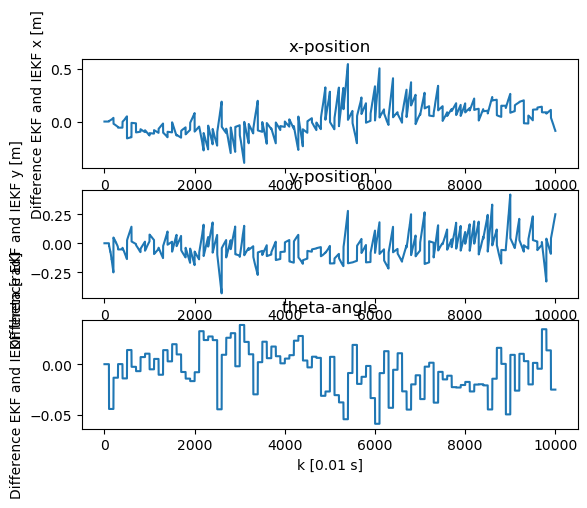

In [49]:
# Initial values - as a comparison

# Noise - must be tuned
  # Process-noise
q_var = [1, 0.8, 2 * np.pi / 180.0]
  # Measurement noise
r_pos_var = [2, 2]
r_vel_var = [10, 2 * np.pi / 180.0]

num_states = 3
num_steps = 10000

run_estimates(
  num_states=num_states,
  num_steps=num_steps,
  q_list=q_var,
  r_pos_list=r_pos_var,
  r_vel_list=r_vel_var
)

EKF
Number of x-estimates with an error greater than 1 m:  7959
Number of x-estimates with an error greater than 2 m:  6326
Number of x-estimates with an error greater than 5 m:  2958

IEKF
Number of x-estimates with an error greater than 1 m:  8050
Number of x-estimates with an error greater than 2 m:  6589
Number of x-estimates with an error greater than 5 m:  3352



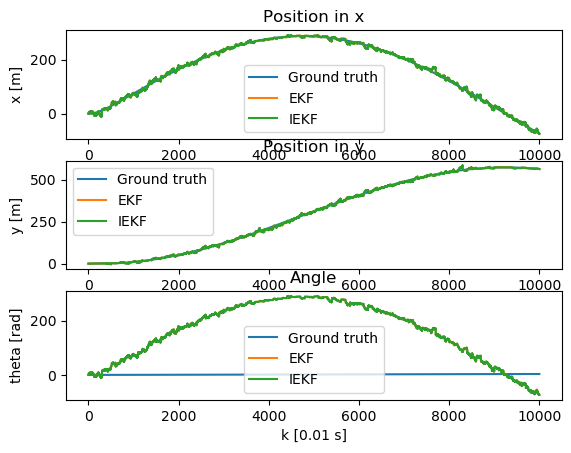

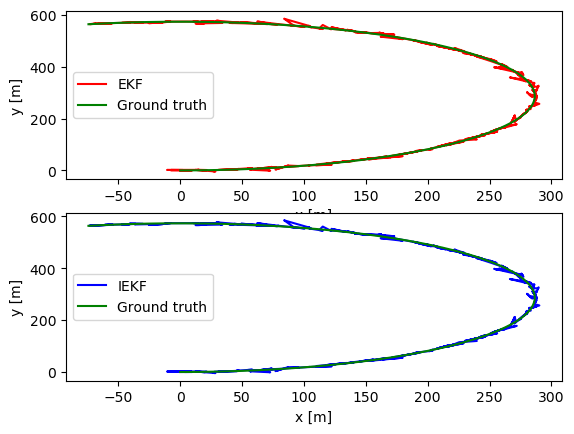

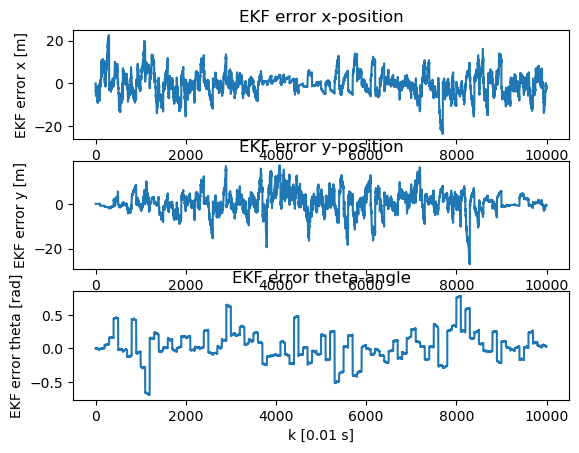

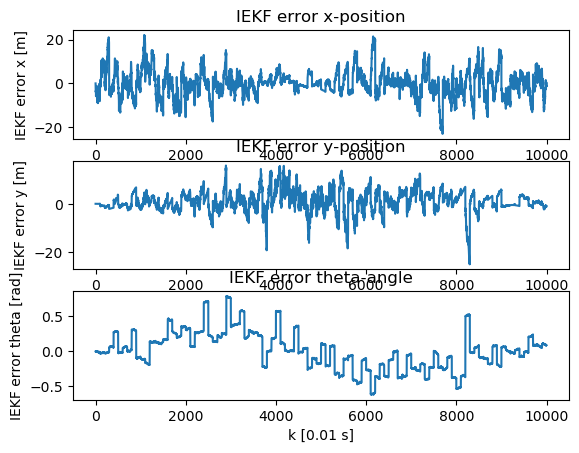

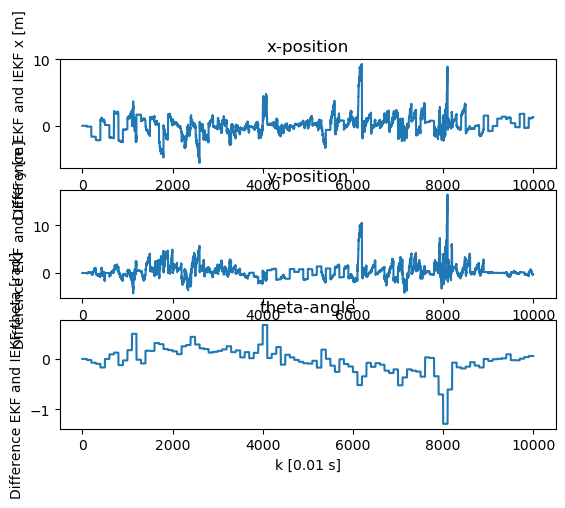

In [50]:
# High linear velocity noise

# Noise - must be tuned
  # Process-noise
q_var = [1, 0.8, 2 * np.pi / 180.0]
  # Measurement noise
r_pos_var = [2, 2]
r_vel_var = [10000, 2 * np.pi / 180.0]

num_states = 3
num_steps = 10000

run_estimates(
  num_states=num_states,
  num_steps=num_steps,
  q_list=q_var,
  r_pos_list=r_pos_var,
  r_vel_list=r_vel_var
)

EKF
Number of x-estimates with an error greater than 1 m:  9687
Number of x-estimates with an error greater than 2 m:  9499
Number of x-estimates with an error greater than 5 m:  8743

IEKF
Number of x-estimates with an error greater than 1 m:  9709
Number of x-estimates with an error greater than 2 m:  9619
Number of x-estimates with an error greater than 5 m:  9209



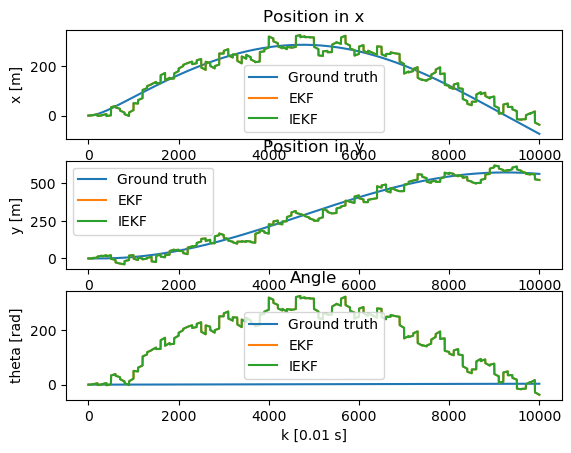

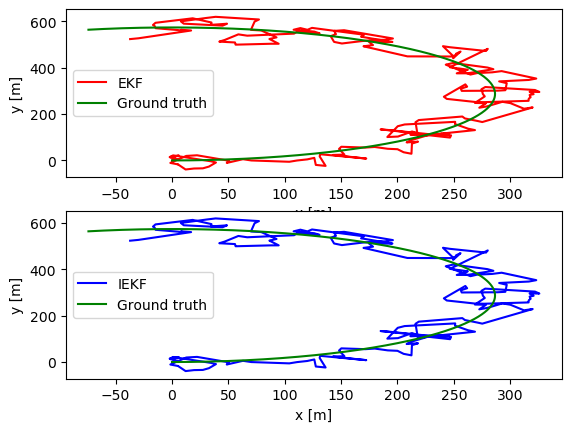

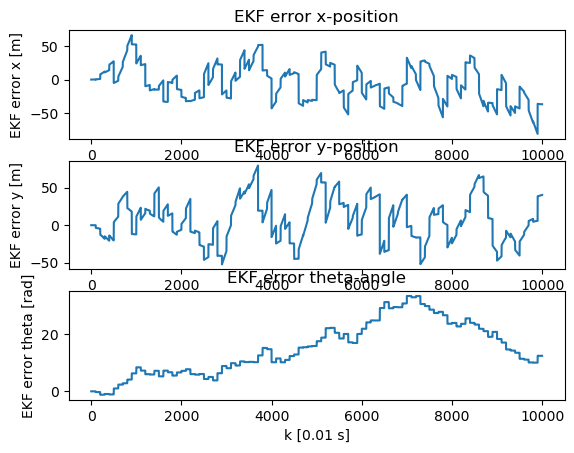

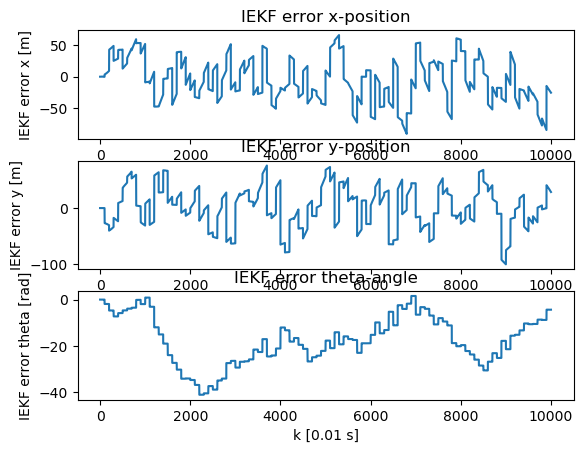

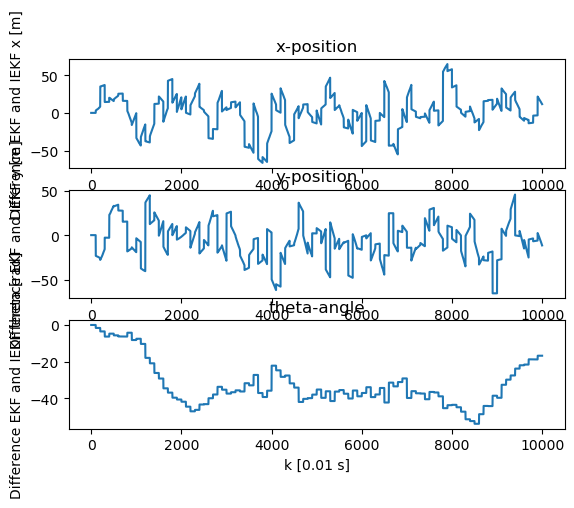

In [51]:
# High position update noise and using it in the EKFs' R-matrix

# Noise - must be tuned
  # Process-noise
q_var = [1, 0.8, 2 * np.pi / 180.0]
  # Measurement noise
r_pos_var = [2000, 2000]
r_vel_var = [10, 2 * np.pi / 180.0]

num_states = 3
num_steps = 10000

run_estimates(
  num_states=num_states,
  num_steps=num_steps,
  q_list=q_var,
  r_pos_list=r_pos_var,
  r_vel_list=r_vel_var
)

EKF
Number of x-estimates with an error greater than 1 m:  9685
Number of x-estimates with an error greater than 2 m:  9505
Number of x-estimates with an error greater than 5 m:  8856

IEKF
Number of x-estimates with an error greater than 1 m:  9744
Number of x-estimates with an error greater than 2 m:  9565
Number of x-estimates with an error greater than 5 m:  8970



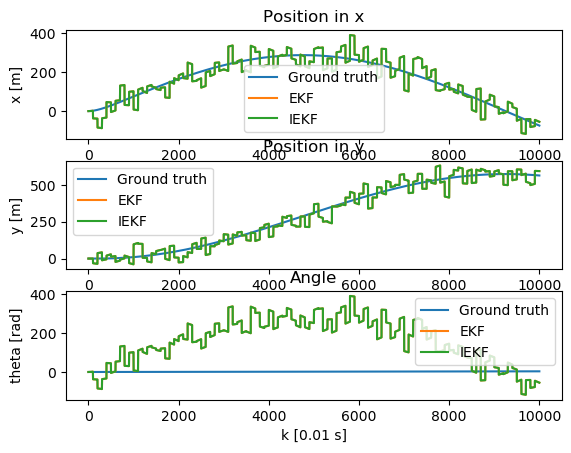

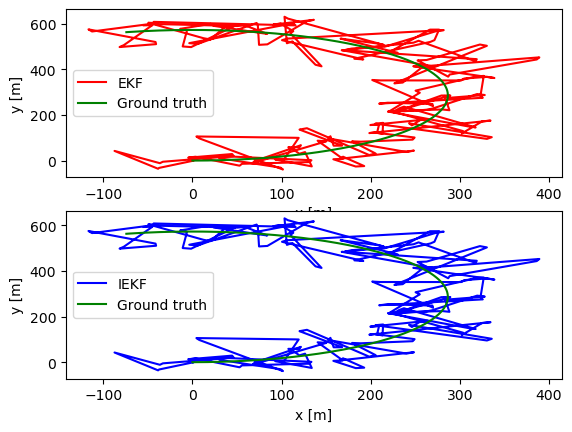

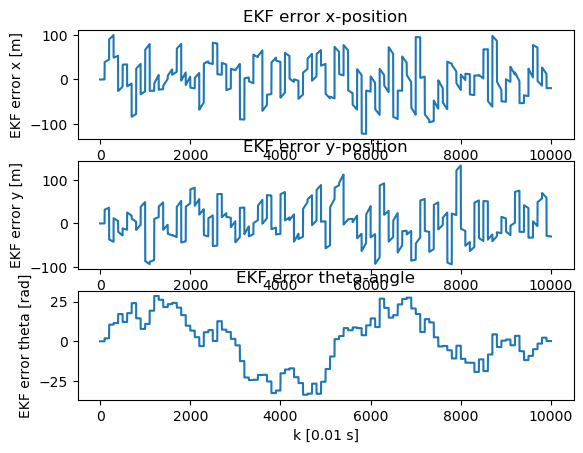

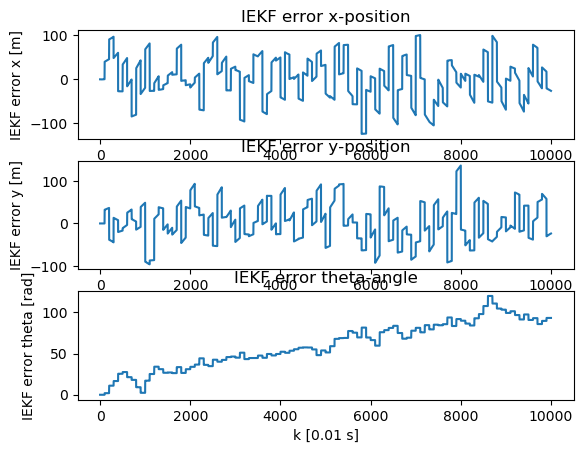

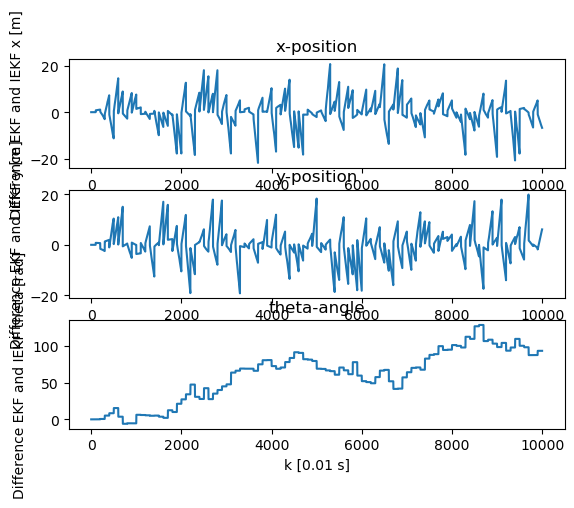

In [52]:
# High position update noise and not using it in the EKFs' R-matrix

# Noise - must be tuned
  # Process-noise
q_var = [1, 0.8, 2 * np.pi / 180.0]
  # Measurement noise
r_pos_var = [2000, 2000]
r_vel_var = [10, 2 * np.pi / 180.0]

num_states = 3
num_steps = 10000

run_estimates(
  num_states=num_states,
  num_steps=num_steps,
  q_list=q_var,
  r_pos_list=r_pos_var,
  r_vel_list=r_vel_var,
  use_r_in_R=False
)

In [53]:
"""
Comments:
  It looks like it is something slightly buggy with the implementation:

    One can see the ground truth in angle having a large offset compared to the estimated state.
    It boggles me that the positional estimate could be so good, with such poor angle estimate.

    When using ipynb and not normal .py scripts, the matplotlib titles are not shown. The titles 
    are therefore partly crammed into the legends or labels, such that one could understand the 
    plots somewhat.

    I would have expected that the IEKF would perform much better compared to the EKF.
    This might be the tuning, which is naturally subpar, as it was done in a hurry, however
    the EKF actually performs better in many cases compared to the IEKF. The IEKF often include
    more measurements with a larger error at both 1, 2 and 5 meters, compared to the EKF. In 
    reality, it is expected to perform better, and not consistently slightly worse or far worse
    than the EKF. It is likely just an implemenation error somewhere that I have overlooked. 

    There is something wierd with the plotting function, as it will sometimes not include all 
    of the values in the plots. For example, the plot 'estimates vs ground truth' only show the 
    IEKF and GT, and does not include the EKF. I have no clue why. As a C++ enjoyer, Python is 
    just wierd.    

    In other words, the output from the estimators will be incorrect, and must be taken with a 
    couple of kgs of NaCl. 

    Why am I handing this in? I have spent far too much time on debugging this assignment. The 
    project thesis is taking up too much time, and it required more priority at the time of 
    writing. Also with the project being started, it makes more sense to spend some time on it, 
    instead of debugging this assignment. 


  Increasing the noise. Only one of the variables have the noise increased at a time, to 
  separate out the effects from increasing the noise. This is therefore a more theoretical 
  exercise, as the noise-levels will be connected in reality, where one should expect an 
  increase in one noise level also results in a connection with another noise level.

  It must also be noted that an increase in one measurement noise level, the process noise has 
  been left untouched. When the measurement-noise was increased, the corresponding R-matrix was
  NOT changed. An argument could be made that the measurement noise matrix, R, can be well-defined 
  by estimates on our or the manufacturer behalf. And such, it makes sense to tune the R-matrix 
  accordingly. I chose not to, however that means that my EKF/IEKF will have too large faith 
  in measurements which have an increased noise-level. 


    Angular velocity:
      Increased the angular noise to 2e9 deg^2 (yes, a variance proportional to a billion). This 
      makes the estimates far noisier, however the system is still able to follow the desired 
      trajectory. This makes some sence, as the noise is integrated, where the expected value
      over time will be zero (as it is unbiased). The position estimates therefore becomes more noisy, however 
      is less affected by a high variance. Combined with good position updates, means that it is able to
      follow the ground truth. I am however impressed that it was able to follow that well though. 

    Linear velocity:
      Increased the noise to 10000 (m/s)^2, which created more noisy estimates, with positional errors
      in approaching 10 meters several times. However, it still managed to achieve proper estimates
      and follow the ground truth. However, the noise will be multiplied with a cos() or sin() of the
      angle, before being integrated. Under the assumption that the angular velocity has relatively 
      little change between the state estimates, one should expect the integration of the unbiased 
      noise to be close to zero. Not quite zero, due to cos() and sin(). 

    To comment on the positional variance used, used a variance in the position measurements in both 
    the linear and the angular velocity noise of 2 meters in each. This is due to assuming a standard
    GNSS, under good circumstances. E.g. little to no multipath and little disturbances from f.ex. the 
    ionosphere.   

    Position:
      Increasing the noise in both x and y simultaneously, which makes the positional measurements 
      have large deviations. This means that the corrections cause large changes, due to having large 
      trust in the measurements. If the R-matrix was tuned similarly to the measurement-noise levels,
      the kalman gain would place little importance in the update step, and thus relying more on the 
      predicted values.

      Comparing the last two sets of values, examplifies the use of proper tuning of the R-matrix.
      If it is properly tuned, it will better be able to account for the uncertainties in the 
      measurements. 


  It is not mentioned in the assignment to change the process noise measurements. Increasing these 
  noise levels, just makes the model expect large values in the states between the iterations. For 
  example, having a large variance in the positions, implies that the system can have somewhat
  larger changes in position. An obvious case is where a constant velocity model is used to describe 
  a system which can turn every so often. A larger noise level implies that it would be better for
  movement with larger motion, such as turning. It will however be suboptimal if the system moves at 
  a relatively straight line, as the system changes far less.

"""


"\nComments:\n  It looks like it is something slightly buggy with the implementation:\n\n    One can see the ground truth in angle having a large offset compared to the estimated state.\n    It boggles me that the positional estimate could be so good, with such poor angle estimate.\n\n    When using ipynb and not normal .py scripts, the matplotlib titles are not shown. The titles \n    are therefore partly crammed into the legends or labels, such that one could understand the \n    plots somewhat.\n\n    I would have expected that the IEKF would perform much better compared to the EKF.\n    This might be the tuning, which is naturally subpar, as it was done in a hurry, however\n    the EKF actually performs better in many cases compared to the IEKF. The IEKF often include\n    more measurements with a larger error at both 1, 2 and 5 meters, compared to the EKF. In \n    reality, it is expected to perform better, and not consistently slightly worse or far worse\n    than the EKF. It is 